**Real estate Price prediction using Multiple linear regression** 

* Student name:**Group 19**:Alex Muturi, Angela Nyaga, Annette Kalekye, Chris Otieno              
* Student pace:part time
* Scheduled project review date/time: 11th September 2023|6:00AM
* Instructor name: Stella Waithera 
* Blog post URL:


**Overview**

give overview of project steps from beginning to recommedations

**Business Problem**

 explain the project’s value for helping a specific stakeholder solve a real-world problem.

**Data understanding**

clearly describe the source and properties of the data to show how useful the data are for solving the problem of interest.

**Loading Libraries**

In [1]:
#loading needed libraries
import pandas as pd
import numpy as np
#data visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

**Import dataset**

In [2]:
#loading our data set for analysis and cleaning
df = pd.read_csv('kc_house_data.csv', index_col=0)
#previewing our dataset
df.head(4)

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
id,,,,,,,,,,,,,,,,,,,,
7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,NONE,Average,7 Average,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,NO,NONE,Average,7 Average,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,NO,NONE,Average,6 Low Average,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062
2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,NO,NONE,Very Good,7 Average,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000


**Data exploration and understanding**

In [3]:
#To get an overview/summary of our dataset, thid includes nn- null values and datatypes
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21597 entries, 7129300520 to 1523300157
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           21597 non-null  object 
 1   price          21597 non-null  float64
 2   bedrooms       21597 non-null  int64  
 3   bathrooms      21597 non-null  float64
 4   sqft_living    21597 non-null  int64  
 5   sqft_lot       21597 non-null  int64  
 6   floors         21597 non-null  float64
 7   waterfront     19221 non-null  object 
 8   view           21534 non-null  object 
 9   condition      21597 non-null  object 
 10  grade          21597 non-null  object 
 11  sqft_above     21597 non-null  int64  
 12  sqft_basement  21597 non-null  object 
 13  yr_built       21597 non-null  int64  
 14  yr_renovated   17755 non-null  float64
 15  zipcode        21597 non-null  int64  
 16  lat            21597 non-null  float64
 17  long           21597 non-null  float

Interpreting the total columns and columns with missing values in the dataframe
+ The DataFrame 'kc_house_data.csv' has a total of 21597 rows and 20 columns.
+ 'waterfront' - This column has 19221 non-null entries; there are some missing values for this variable. The data type is 'object,'; it is explaining a waterfront feature of the houses.
+ 'view' - This column has 21534 non-null entries; there are some missing values for this variable. The data type is 'object,'; it is explaining houses with a view.
+ 'yr_renovated' - This column has 21534 non-null entries; there are some missing values for this variable. The data type is 'float,'; it represents the year a house was renovated.


In [4]:
#finding the statistical summary of our dataset
df.describe(include = 'all')

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
count,21597,2.159700e+04,21597.000000,21597.000000,21597.000000,2.159700e+04,21597.000000,19221,21534,21597,21597,21597.000000,21597,21597.000000,17755.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000
unique,372,NaN,NaN,NaN,NaN,NaN,NaN,2,5,5,11,NaN,304,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,6/23/2014,NaN,NaN,NaN,NaN,NaN,NaN,NO,NONE,Average,7 Average,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,142,NaN,NaN,NaN,NaN,NaN,NaN,19075,19422,14020,8974,NaN,12826,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,5.402966e+05,3.373200,2.115826,2080.321850,1.509941e+04,1.494096,NaN,NaN,NaN,NaN,1788.596842,NaN,1970.999676,83.636778,98077.951845,47.560093,-122.213982,1986.620318,12758.283512
std,NaN,3.673681e+05,0.926299,0.768984,918.106125,4.141264e+04,0.539683,NaN,NaN,NaN,NaN,827.759761,NaN,29.375234,399.946414,53.513072,0.138552,0.140724,685.230472,27274.441950
min,NaN,7.800000e+04,1.000000,0.500000,370.000000,5.200000e+02,1.000000,NaN,NaN,NaN,NaN,370.000000,NaN,1900.000000,0.000000,98001.000000,47.155900,-122.519000,399.000000,651.000000
25%,NaN,3.220000e+05,3.000000,1.750000,1430.000000,5.040000e+03,1.000000,NaN,NaN,NaN,NaN,1190.000000,NaN,1951.000000,0.000000,98033.000000,47.471100,-122.328000,1490.000000,5100.000000
50%,NaN,4.500000e+05,3.000000,2.250000,1910.000000,7.618000e+03,1.500000,NaN,NaN,NaN,NaN,1560.000000,NaN,1975.000000,0.000000,98065.000000,47.571800,-122.231000,1840.000000,7620.000000
75%,NaN,6.450000e+05,4.000000,2.500000,2550.000000,1.068500e+04,2.000000,NaN,NaN,NaN,NaN,2210.000000,NaN,1997.000000,0.000000,98118.000000,47.678000,-122.125000,2360.000000,10083.000000


**Data cleaning**

We will identify and correct any data inconsistencies within our dataset, deal with missing values and invalid entries

In [5]:
df.isna()# Checks missing values

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
id,,,,,,,,,,,,,,,,,,,,
7129300520,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False
6414100192,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
5631500400,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False
2487200875,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1954400510,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
263000018,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
6600060120,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1523300141,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False


In [6]:
df.isna().sum() #to see missing value

date                0
price               0
bedrooms            0
bathrooms           0
sqft_living         0
sqft_lot            0
floors              0
waterfront       2376
view               63
condition           0
grade               0
sqft_above          0
sqft_basement       0
yr_built            0
yr_renovated     3842
zipcode             0
lat                 0
long                0
sqft_living15       0
sqft_lot15          0
dtype: int64

view and waterfront are both categorical data types we replace their missing values using mode.The % of data missing is below 15% we do not expect that this repalcement will affect our model outcome.


In [7]:
mode_view = df['view'].mode()[0]
df['view'].fillna(mode_view, inplace=True)

In [8]:
mode_waterfront = df['waterfront'].mode()[0]
df['waterfront'].fillna(mode_waterfront, inplace=True)

In [9]:
#replacing the yr_renovated with the median, we need this column in our analysis
median_yr_renovated = df['yr_renovated'].median()

In [10]:
df['yr_renovated'].fillna(df['yr_renovated'].median(),inplace=True)

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21597 entries, 7129300520 to 1523300157
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           21597 non-null  object 
 1   price          21597 non-null  float64
 2   bedrooms       21597 non-null  int64  
 3   bathrooms      21597 non-null  float64
 4   sqft_living    21597 non-null  int64  
 5   sqft_lot       21597 non-null  int64  
 6   floors         21597 non-null  float64
 7   waterfront     21597 non-null  object 
 8   view           21597 non-null  object 
 9   condition      21597 non-null  object 
 10  grade          21597 non-null  object 
 11  sqft_above     21597 non-null  int64  
 12  sqft_basement  21597 non-null  object 
 13  yr_built       21597 non-null  int64  
 14  yr_renovated   21597 non-null  float64
 15  zipcode        21597 non-null  int64  
 16  lat            21597 non-null  float64
 17  long           21597 non-null  float

The output above confirms there is no more missing data in each column, all missing values have been handled and our data is noe ready for further analysis.

**Exploratory Data Analysis**

+ We visualize the data to gain insights, identify patterns and understand relationshipd between the data variables.This will also prepare our data for further modeling.


**Data visualization**

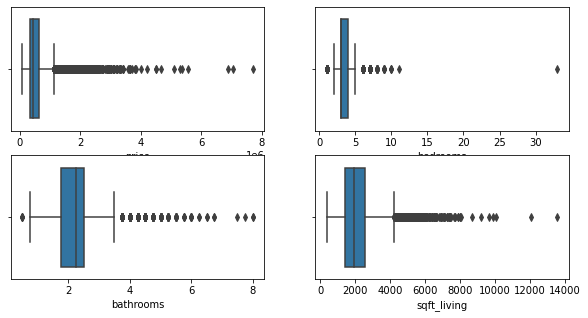

In [12]:
#finding outliers in our dataset with numerical columns
fig, axs = plt.subplots(2,2, figsize = (10,5))
plt1 = sns.boxplot(data = df,x='price', ax = axs[0,0])
plt2 = sns.boxplot(data = df,x='bedrooms', ax = axs[0,1])
plt3 = sns.boxplot(data = df,x='bathrooms', ax = axs[1,0])
plt4 = sns.boxplot(data = df,x='sqft_living', ax = axs[1,1])

plt.show()

price and sqft_living have considerable outliers

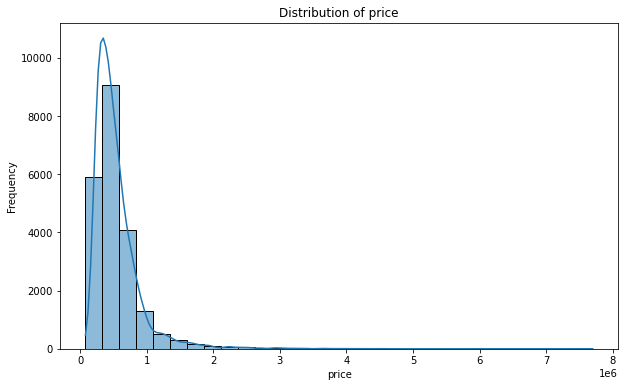

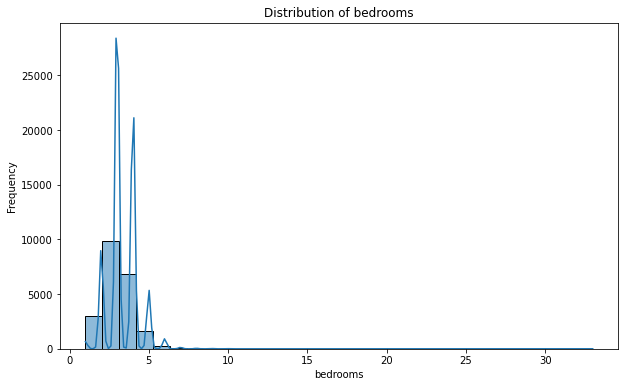

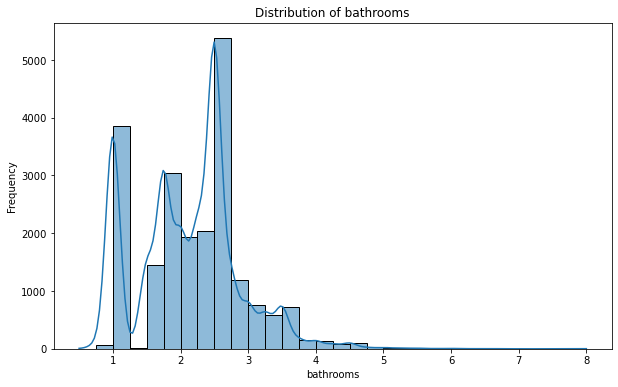

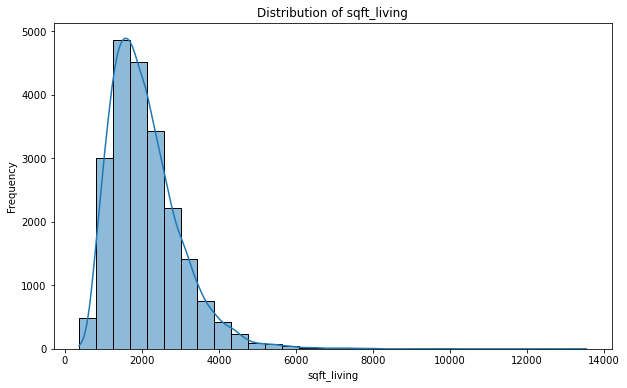

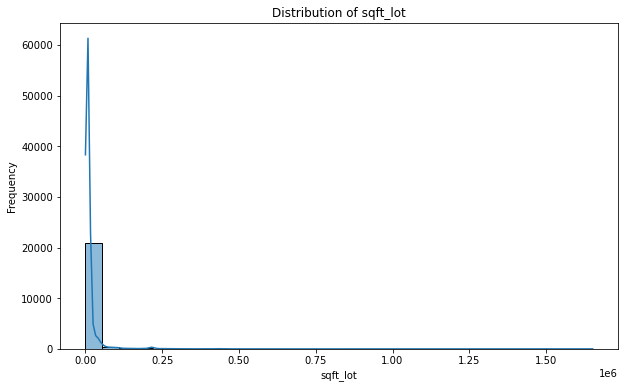

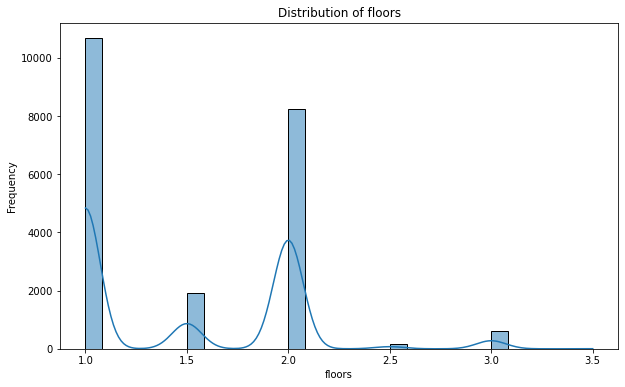

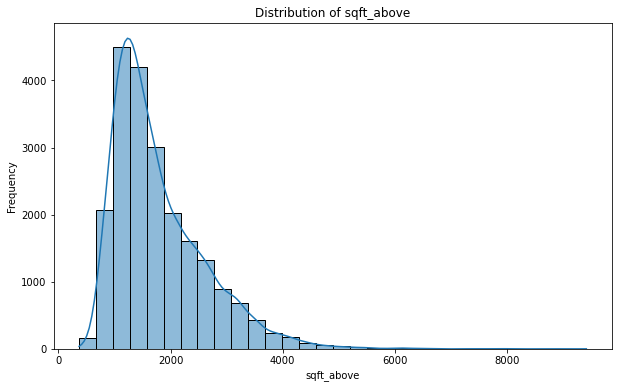

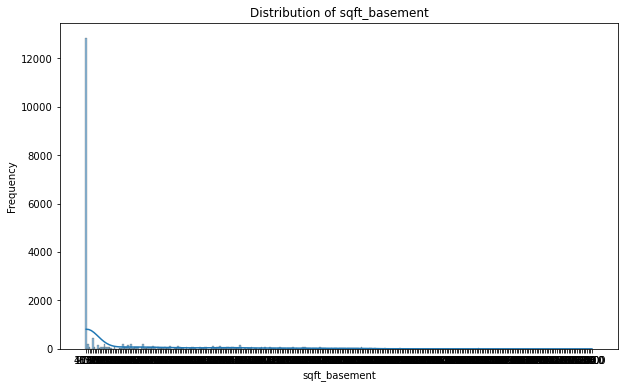

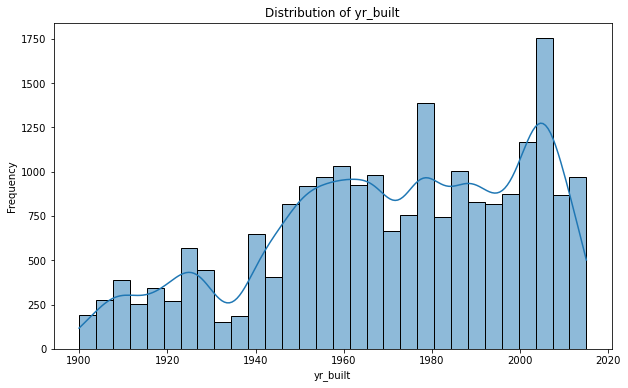

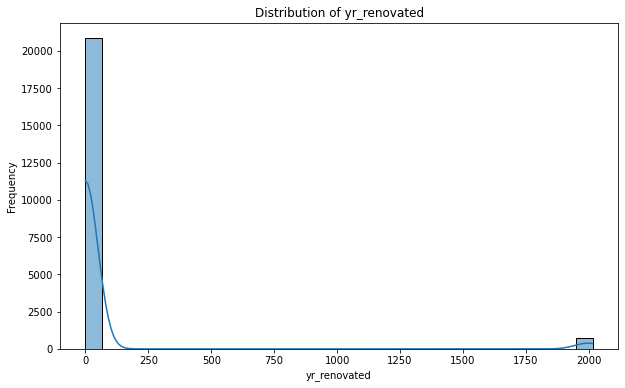

In [13]:
# univariate analysis
numerical_columns= ['price','bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',  'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated']
for col in numerical_columns:
    plt.figure(figsize=(10,6))
    sns.histplot(df[col], bins=30, kde=True)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.show()

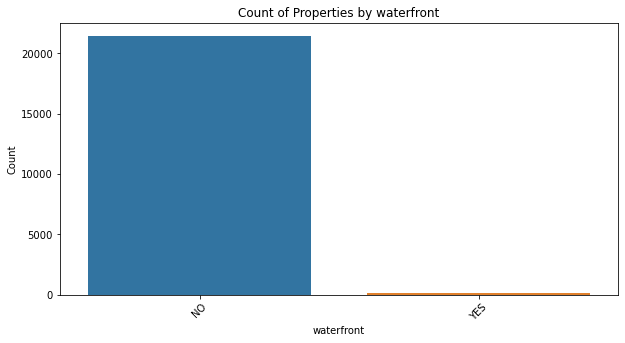

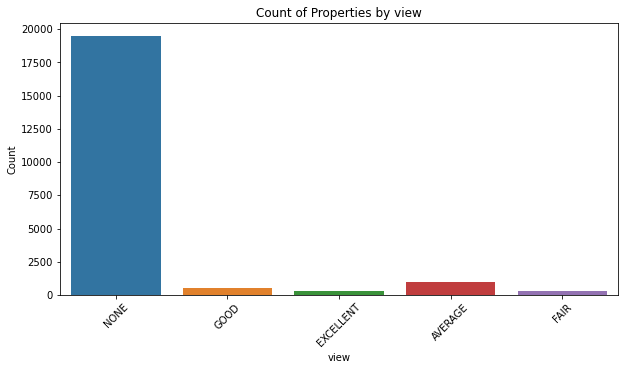

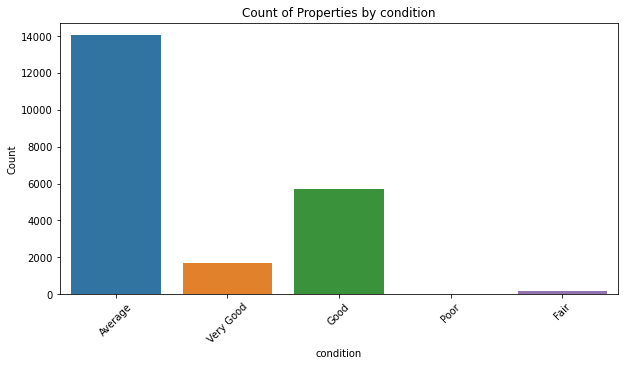

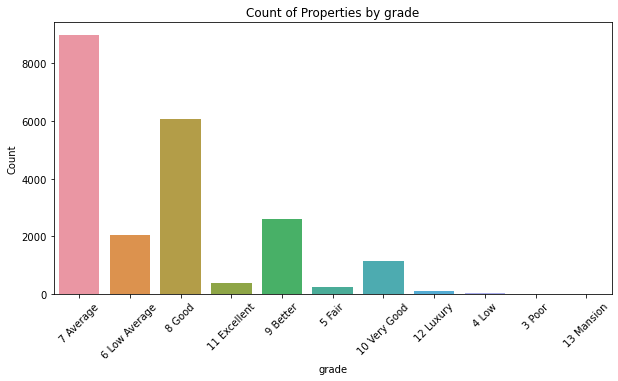

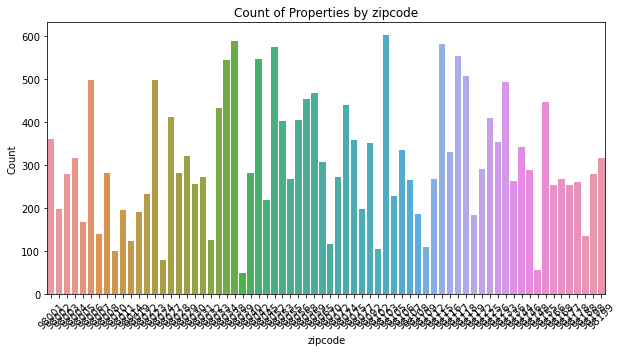

In [14]:
# Bar plot for categorical columns
categorical_columns = ['waterfront', 'view', 'condition', 'grade', 'zipcode']
for col in categorical_columns:
    plt.figure(figsize=(10, 5))
    sns.countplot(data=df, x=col)
    plt.title(f'Count of Properties by {col}')
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.show()

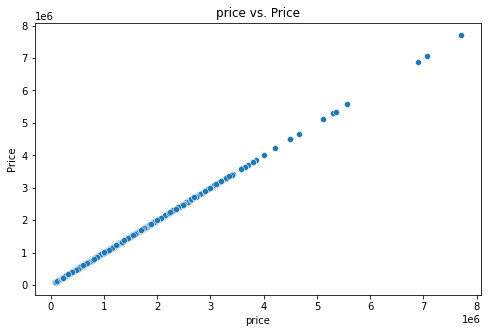

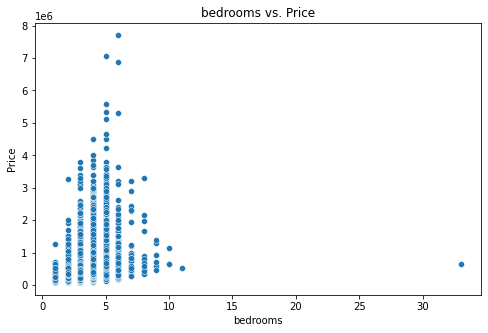

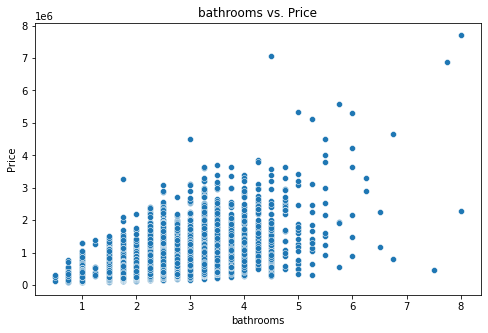

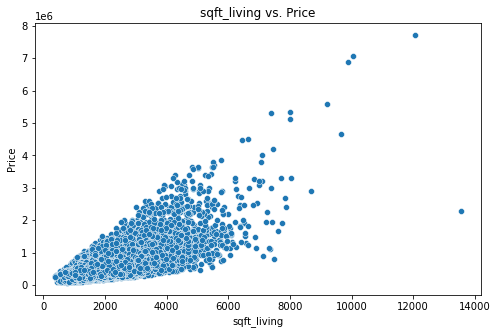

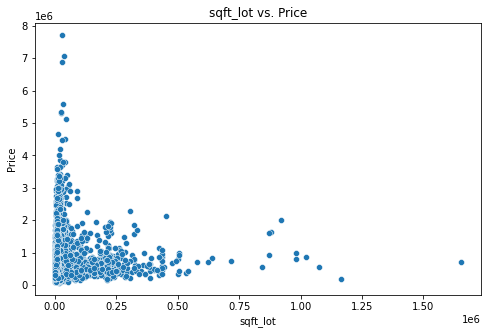

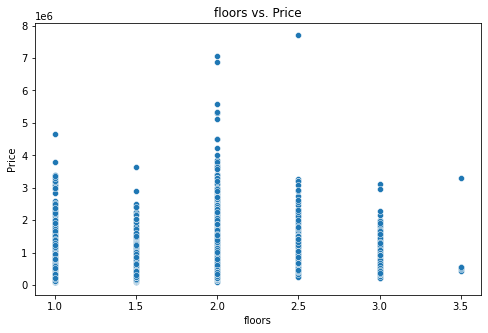

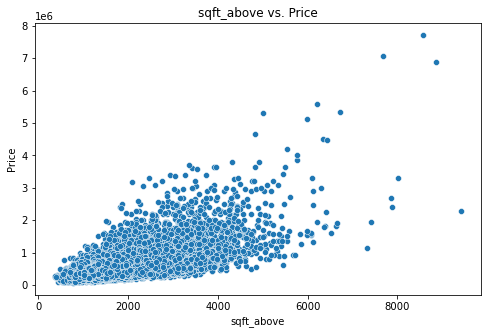

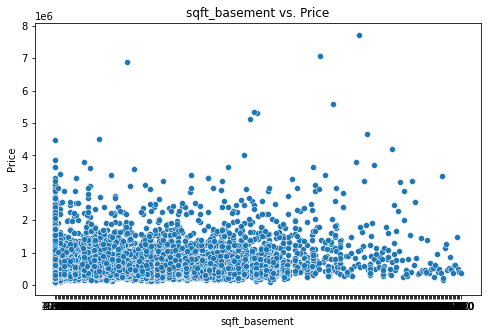

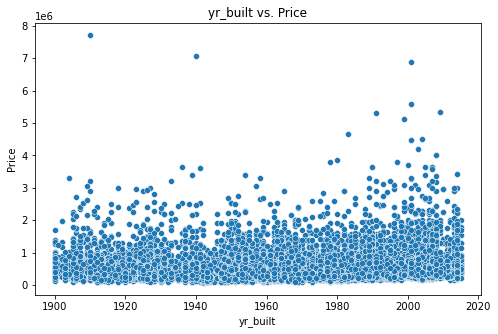

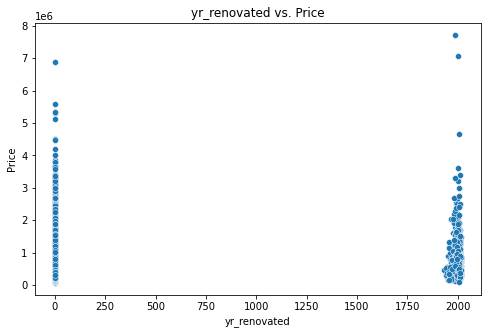

In [15]:
# Bivariate analysis
# Scatter plots for relationships between numerical columns and price

for col in numerical_columns:
    plt.figure(figsize=(8, 5))
    sns.scatterplot(data=df, x=col, y='price')
    plt.title(f'{col} vs. Price')
    plt.xlabel(col)
    plt.ylabel('Price')
    plt.show()

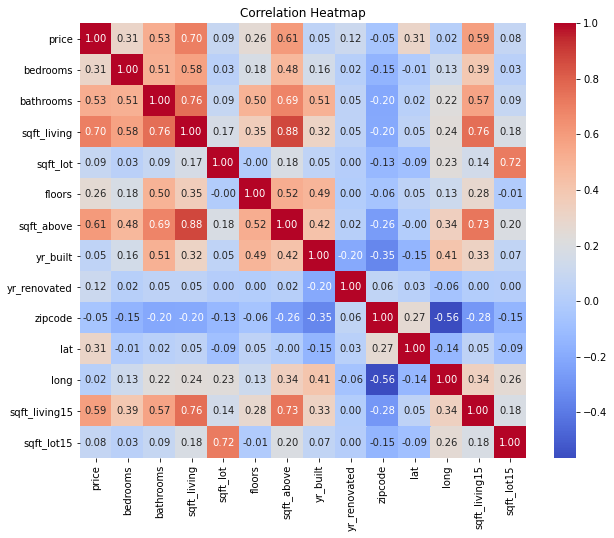

In [16]:
# Correlation matrix heatmap to check what variables are highly corrrelated
correlation_matrix = df.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()

****Multiple linear regression****

In [17]:
# import model 
from sklearn.linear_model import LinearRegression

In [18]:
df.corr()['price']

price            1.000000
bedrooms         0.308787
bathrooms        0.525906
sqft_living      0.701917
sqft_lot         0.089876
floors           0.256804
sqft_above       0.605368
yr_built         0.053953
yr_renovated     0.117855
zipcode         -0.053402
lat              0.306692
long             0.022036
sqft_living15    0.585241
sqft_lot15       0.082845
Name: price, dtype: float64

The correlation coefficients between the 'price' column and other columns in your dataset provide insights into the relationships between these variables and the price of properties. Correlation measures the strength and direction of the linear relationship between two variables, with values ranging from -1 to 1. Here's how to interpret the correlations to 'price':

1. **Strong Positive Correlations:**
   - 'sqft_living' (0.701917): This variable has a strong positive correlation with 'price,' indicating that as the square footage of the living space increases, the price tends to increase significantly. This suggests that larger living spaces are associated with higher property prices.

2. **Moderate Positive Correlations:**
   - 'bathrooms' (0.525906): The number of bathrooms also has a moderate positive correlation with 'price.' This suggests that properties with more bathrooms tend to have higher prices.
   - 'sqft_above' (0.605368): The square footage of the space above the ground level has a moderate positive correlation with 'price,' implying that larger above-ground space is associated with higher prices.
   - 'sqft_living15' (0.585241): The square footage of the living space in 2015 (if relevant) has a moderate positive correlation with 'price,' indicating that larger living spaces in 2015 are associated with higher prices.
   - 'lat' (0.306692): The latitude of the location has a moderate positive correlation with 'price.' This suggests that properties located at higher latitudes tend to have higher prices.

3. **Weak Positive Correlations:**
   - 'floors' (0.256804): The number of floors has a weak positive correlation with 'price,' indicating that properties with more floors tend to have slightly higher prices.
   - 'bedrooms' (0.308787): The number of bedrooms has a weak positive correlation with 'price,' suggesting that properties with more bedrooms tend to have slightly higher prices.
   - 'yr_renovated' (0.117855): The year of renovation has a weak positive correlation with 'price.' This implies that more recently renovated properties may have slightly higher prices.

4. **Weak Negative Correlation:**
   - 'zipcode' (-0.053402): The zip code has a weak negative correlation with 'price.' This suggests that there may be a slight decrease in price as you move to different zip codes, but the effect is relatively small.
   - 'long' (0.022036): The longitude of the location has a very weak positive correlation with 'price,' indicating that there is almost no relationship between longitude and price.

It's important to note that correlation does not imply causation, and other factors not included in this analysis may also influence property prices. Additionally, while correlation measures linear relationships, there may be non-linear relationships that are not captured by these coefficients. Further analysis, such as regression modeling, can help explore and quantify the relationships more comprehensively.

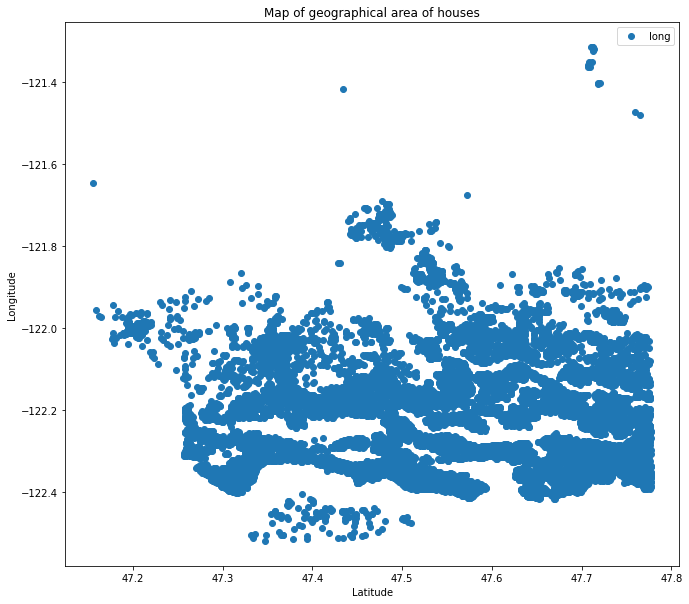

In [19]:
# fig, axes = plt.subplots(figsize=(11, 3)
df.plot(x= 'lat', y='long', style='o', figsize=(11,10))
plt.title('Map of geographical area of houses')
plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.show()


In [20]:
latbins = pd.cut(df.lat, 4, labels=[f'lat{k}' for k in range(1,4+1)], retbins=True)
longbins = pd.cut(df.long, 4, labels=[f'long{k}' for k in range(1,4+1)], retbins=True)

df['geog_bins'] = [f'{latbins[0][row]}_{longbins[0][row]}' for row in df.index]


In [21]:
df

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,...,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,geog_bins
id,,,,,,,,,,,,,,,,,,,,,
7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NO,NONE,Average,...,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650,lat3_long1
6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,NO,NONE,Average,...,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639,lat4_long1
5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,NO,NONE,Average,...,770,0.0,1933,0.0,98028,47.7379,-122.233,2720,8062,lat4_long1
2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,NO,NONE,Very Good,...,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000,lat3_long1
1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,NO,NONE,Average,...,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503,lat3_long2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
263000018,5/21/2014,360000.0,3,2.50,1530,1131,3.0,NO,NONE,Average,...,1530,0.0,2009,0.0,98103,47.6993,-122.346,1530,1509,lat4_long1
6600060120,2/23/2015,400000.0,4,2.50,2310,5813,2.0,NO,NONE,Average,...,2310,0.0,2014,0.0,98146,47.5107,-122.362,1830,7200,lat3_long1
1523300141,6/23/2014,402101.0,2,0.75,1020,1350,2.0,NO,NONE,Average,...,1020,0.0,2009,0.0,98144,47.5944,-122.299,1020,2007,lat3_long1


In [22]:
df.geog_bins.value_counts()



lat4_long1                                                                                                                                                                                                                                                                        5284
lat3_long1                                                                                                                                                                                                                                                                        3780
lat3_long2                                                                                                                                                                                                                                                                        3309
lat4_long2                                                                                                                                                         

In [25]:
from math import radians
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split

df['lat'] = df['lat'].apply(radians)
df['long'] = df['long'].apply(radians)

X = df[['lat', 'long']].values
y = df['price'].values

X_train, X_test, y_train, y_test \
  = train_test_split(X, y, test_size=0.25)

nbrs = KNeighborsRegressor(weights='distance', metric='haversine')

nbrs.fit(X_train, y_train)

y_pred = nbrs.predict(X_test)

In [33]:
y_pred

array([411615.35202929, 229895.68947169, 762304.80107568, ...,
       473932.61542868, 401847.31949415, 868444.33564055])

In [26]:
X = df[['lat', 'long']].values
y = df['price'].values

X_train, X_test, y_train, y_test \
  = train_test_split(X, y, test_size=0.25)

clf=KNeighborsRegressor(11)
clf.fit(X_train,y_train)

y_pred = clf.predict(X_test)



In [27]:
y_pred

array([335859.09090909, 698545.45454545, 412654.54545455, ...,
       372995.45454545, 751136.36363636, 943559.09090909])

In [39]:
print(mean_squared_error(y_test,y_pred))

NameError: name 'mean_squared_error' is not defined